In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from prepare_data import *
from data import *

In [224]:
def prepare_model(device, model):
    # load model, criterion, optimizer, and learning rate scheduler
    
    # Create an empty model and move it to the designated computing device
    model=model.to(device)


    return model

def train_single_model(model, criterion, optimizer, scheduler, device, dataloaders,epoch):
    
    # prepare the model
    model=prepare_model(device,model)
    
    # store the results of our training
    training_losses=[]
    training_accs=[]
    val_losses=[]
    val_accs=[]

    for i in range(epoch):
        # train the model in each epoch
        model.train()
        for batch_idx, (data, target) in enumerate(dataloaders[0]):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad() # clear the old gradients 
            output = model(data) # compute outputs of the fc layer 
            loss = criterion(output, target) 
            loss.backward() # compute gradient for every variables with requires_grad=True
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        print("finish a epoch of training")
            
        # test the model with the training data:
        model.eval() # sets model in evaluation (inference) mode.  
        training_loss = 0 
        correct = 0
        with torch.no_grad(): # stop storing gradients for the variables
            for data, target in dataloaders[0]:
                data, target = data.to(device), target.to(device)
                output = model(data)
                training_loss+=criterion(output, target)
                pred = output.argmax(dim=1, keepdim=True) # get the index of maximum fc output. Q4. Why?
                correct += pred.eq(target.view_as(pred)).sum().item()
        training_loss /= len(dataloaders[0].dataset)
        training_losses.append(training_loss)
        training_acc=correct / len(dataloaders[0].dataset)
        training_accs.append(training_acc)
        
        
        # test the model with validation data in each epoch
        model.eval() # sets model in evaluation (inference) mode. 
        val_loss = 0 
        correct = 0
        with torch.no_grad(): # stop storing gradients for the variables
            for data, target in dataloaders[1]:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss+=criterion(output, target)
                pred = output.argmax(dim=1, keepdim=True) # get the index of maximum fc output. 
                correct += pred.eq(target.view_as(pred)).sum().item()
        val_loss /= len(dataloaders[1].dataset)
        val_losses.append(val_loss)
        val_acc=correct / len(dataloaders[1].dataset)
        val_accs.append(val_acc)
        print("epoch_num: "+str(i))
        print("train_loss: "+str(training_loss))
        print("val_loss: "+str(val_loss))

    torch.save(model.state_dict(), "food-101/state_dict_model2.pt")
    return model,training_losses,training_accs,val_losses,val_accs

In [259]:
# Fine-tuned version
class resnet(nn.Module):
    def __init__(self):
        super(resnet, self).__init__()
        temp=models.resnet18(pretrained=True)
        num_ftrs = temp.fc.in_features
        temp.fc = nn.Linear(num_ftrs, 20)
        model_ft = temp.to("cuda:0")
        self.model=model_ft
        
    def forward(self, x):
        x=self.model(x)
        return x

In [260]:
training_address="food-101/train.csv"
test_address="food-101/test.csv"
train,val,test=get_dataloaders(training_address, test_address, args=None)
model=resnet()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.0001)
model
a=[train,val,test]
m1,tl1,tc1,vl1,vc1=train_single_model(model, criterion, optimizer, scheduler=None, device="cuda:0", dataloaders=a,epoch=30)

finish a epoch of training
epoch_num: 0
train_loss: tensor(0.0200, device='cuda:0')
val_loss: tensor(0.0198, device='cuda:0')
finish a epoch of training
epoch_num: 1
train_loss: tensor(0.0065, device='cuda:0')
val_loss: tensor(0.0162, device='cuda:0')
finish a epoch of training
epoch_num: 2
train_loss: tensor(0.0022, device='cuda:0')
val_loss: tensor(0.0175, device='cuda:0')
finish a epoch of training
epoch_num: 3
train_loss: tensor(0.0005, device='cuda:0')
val_loss: tensor(0.0166, device='cuda:0')
finish a epoch of training
epoch_num: 4
train_loss: tensor(0.0003, device='cuda:0')
val_loss: tensor(0.0172, device='cuda:0')
finish a epoch of training
epoch_num: 5
train_loss: tensor(0.0006, device='cuda:0')
val_loss: tensor(0.0190, device='cuda:0')
finish a epoch of training
epoch_num: 6
train_loss: tensor(0.0006, device='cuda:0')
val_loss: tensor(0.0195, device='cuda:0')
finish a epoch of training
epoch_num: 7
train_loss: tensor(0.0010, device='cuda:0')
val_loss: tensor(0.0218, device='c

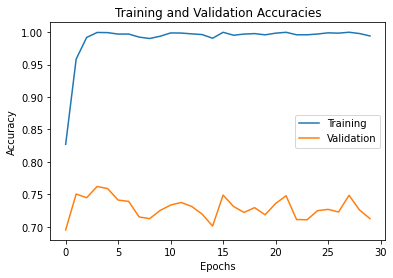

In [261]:
import matplotlib.pyplot as plt
plt.plot(tc1, label='Training')
plt.plot(vc1, label='Validation')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [262]:
tl=[]
for i in tl1:
    tl.append(i.cpu().item())
vl=[]
for i in vl1:
    vl.append(i.cpu().item())

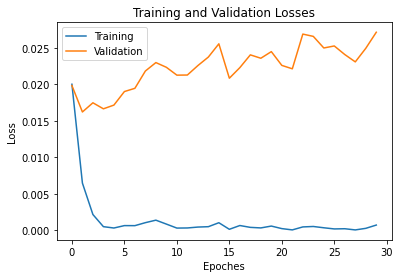

In [263]:
plt.plot(list(tl), label='Training')
plt.plot(list(vl), label='Validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [264]:
m1.eval() # sets model in evaluation (inference) mode. 
correct = 0
device="cuda:0"
with torch.no_grad(): # stop storing gradients for the variables
    for data, target in a[2]:
        data, target = data.to(device), target.to(device)
        output = m1(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of maximum fc output. 
        correct += pred.eq(target.view_as(pred)).sum().item()
    val_acc=correct / len(a[2].dataset)

In [265]:
val_acc

0.7198

In [266]:
torch.save(model.state_dict(), "food-101/resnet_fl.pt")

In [256]:
training_address="food-101/train.csv"
test_address="food-101/test.csv"
train,val,test=get_dataloaders(training_address, test_address, args=None)
model=resnet()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)
a=[train,val,test]
m1,tl1,tc1,vl1,vc1=train_single_model(model, criterion, optimizer, scheduler=None, device="cuda:0", dataloaders=a,epoch=5)

finish a epoch of training
epoch_num: 0
train_loss: tensor(0.0640, device='cuda:0')
val_loss: tensor(0.0414, device='cuda:0')
finish a epoch of training
epoch_num: 1
train_loss: tensor(0.0499, device='cuda:0')
val_loss: tensor(0.0348, device='cuda:0')
finish a epoch of training
epoch_num: 2
train_loss: tensor(0.0496, device='cuda:0')
val_loss: tensor(0.0389, device='cuda:0')
finish a epoch of training
epoch_num: 3
train_loss: tensor(0.0433, device='cuda:0')
val_loss: tensor(0.0406, device='cuda:0')
finish a epoch of training
epoch_num: 4
train_loss: tensor(0.0230, device='cuda:0')
val_loss: tensor(0.0328, device='cuda:0')


In [257]:
model.eval() # sets model in evaluation (inference) mode. 
correct = 0
device="cuda:0"
with torch.no_grad(): # stop storing gradients for the variables
    for data, target in a[2]:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of maximum fc output. 
        correct += pred.eq(target.view_as(pred)).sum().item()
    val_acc=correct / len(a[2].dataset)

In [258]:
val_acc

0.555

In [80]:
model = resnet()
model.load_state_dict(torch.load("food-101/state_dict_model2.pt"))

<All keys matched successfully>

In [230]:
class resnet(nn.Module):
    def __init__(self):
        super(resnet, self).__init__()
        new=models.resnet18(pretrained=True)
        self.conv1=new.conv1
        self.bn1=new.bn1
        self.relu=new.relu
        self.maxpool=new.maxpool
        self.layer1=new.layer1
        self.layer2=new.layer2
        self.layer3=new.layer3
        self.avgpool=new.avgpool
        self.fc=nn.Linear(256, 20)
    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.maxpool(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.avgpool(x)
        x=x.view(-1,256)
        x=self.fc(x)
        return x

In [231]:
training_address="food-101/train.csv"
test_address="food-101/test.csv"
train,val,test=get_dataloaders(training_address, test_address, args=None)
model=resnet()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.0001)
model.to("cuda:0")
m1,tl1,tc1,vl1,vc1=train_single_model(model, criterion, optimizer, scheduler=None, device="cuda:0", dataloaders=a,epoch=13)

finish a epoch of training
epoch_num: 0
train_loss: tensor(0.0599, device='cuda:0')
val_loss: tensor(0.0372, device='cuda:0')
finish a epoch of training
epoch_num: 1
train_loss: tensor(0.0471, device='cuda:0')
val_loss: tensor(0.0309, device='cuda:0')
finish a epoch of training
epoch_num: 2
train_loss: tensor(0.0382, device='cuda:0')
val_loss: tensor(0.0277, device='cuda:0')
finish a epoch of training
epoch_num: 3
train_loss: tensor(0.0339, device='cuda:0')
val_loss: tensor(0.0274, device='cuda:0')
finish a epoch of training
epoch_num: 4
train_loss: tensor(0.0285, device='cuda:0')
val_loss: tensor(0.0267, device='cuda:0')
finish a epoch of training
epoch_num: 5
train_loss: tensor(0.0282, device='cuda:0')
val_loss: tensor(0.0324, device='cuda:0')
finish a epoch of training
epoch_num: 6
train_loss: tensor(0.0204, device='cuda:0')
val_loss: tensor(0.0310, device='cuda:0')
finish a epoch of training
epoch_num: 7
train_loss: tensor(0.0153, device='cuda:0')
val_loss: tensor(0.0343, device='c

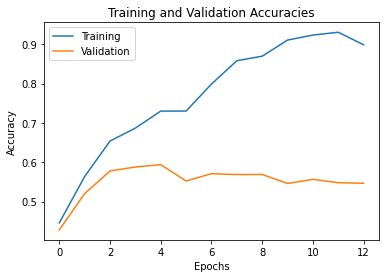

In [232]:
plt.plot(tc1, label='Training')
plt.plot(vc1, label='Validation')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

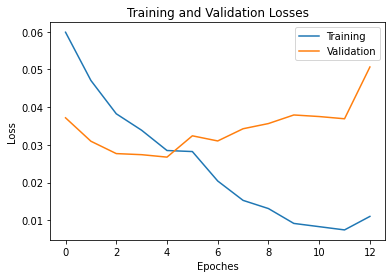

In [233]:
tl=[]
for i in tl1:
    tl.append(i.cpu().item())
vl=[]
for i in vl1:
    vl.append(i.cpu().item())
plt.plot(list(tl), label='Training')
plt.plot(list(vl), label='Validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [234]:
model.eval() # sets model in evaluation (inference) mode. 
correct = 0
device="cuda:0"
with torch.no_grad(): # stop storing gradients for the variables
    for data, target in a[2]:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of maximum fc output. 
        correct += pred.eq(target.view_as(pred)).sum().item()
    val_acc=correct / len(a[2].dataset)
val_acc

0.53

In [237]:
training_address="food-101/train.csv"
test_address="food-101/test.csv"
train,val,test=get_dataloaders(training_address, test_address, args=None)
model=resnet()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)
model.to("cuda:0")
m1,tl1,tc1,vl1,vc1=train_single_model(model, criterion, optimizer, scheduler=None, device="cuda:0", dataloaders=a,epoch=4)

finish a epoch of training
epoch_num: 0
train_loss: tensor(0.0736, device='cuda:0')
val_loss: tensor(0.0446, device='cuda:0')
finish a epoch of training
epoch_num: 1
train_loss: tensor(0.0605, device='cuda:0')
val_loss: tensor(0.0371, device='cuda:0')
finish a epoch of training
epoch_num: 2
train_loss: tensor(0.0533, device='cuda:0')
val_loss: tensor(0.0334, device='cuda:0')
finish a epoch of training
epoch_num: 3
train_loss: tensor(0.0489, device='cuda:0')
val_loss: tensor(0.0316, device='cuda:0')


In [238]:
model.eval() # sets model in evaluation (inference) mode. 
correct = 0
device="cuda:0"
with torch.no_grad(): # stop storing gradients for the variables
    for data, target in a[2]:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of maximum fc output. 
        correct += pred.eq(target.view_as(pred)).sum().item()
    val_acc=correct / len(a[2].dataset)
val_acc

0.4756

In [239]:
class resnet(nn.Module):
    def __init__(self):
        super(resnet, self).__init__()
        new=models.resnet18(pretrained=True)
        self.conv1=new.conv1
        self.bn1=new.bn1
        self.relu=new.relu
        self.maxpool=new.maxpool
        self.layer1=new.layer1
        self.layer2=new.layer2
        self.avgpool=new.avgpool
        self.fc=nn.Linear(128, 20)
    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.maxpool(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.avgpool(x)
        x=x.view(-1,128)
        x=self.fc(x)
        return x

In [240]:
training_address="food-101/train.csv"
test_address="food-101/test.csv"
train,val,test=get_dataloaders(training_address, test_address, args=None)
model=resnet()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)
m1,tl1,tc1,vl1,vc1=train_single_model(model, criterion, optimizer, scheduler=None, device="cuda:0", dataloaders=a,epoch=10)

finish a epoch of training
epoch_num: 0
train_loss: tensor(0.0694, device='cuda:0')
val_loss: tensor(0.0418, device='cuda:0')
finish a epoch of training
epoch_num: 1
train_loss: tensor(0.0605, device='cuda:0')
val_loss: tensor(0.0369, device='cuda:0')
finish a epoch of training
epoch_num: 2
train_loss: tensor(0.0516, device='cuda:0')
val_loss: tensor(0.0321, device='cuda:0')
finish a epoch of training
epoch_num: 3
train_loss: tensor(0.0492, device='cuda:0')
val_loss: tensor(0.0314, device='cuda:0')
finish a epoch of training
epoch_num: 4
train_loss: tensor(0.0487, device='cuda:0')
val_loss: tensor(0.0325, device='cuda:0')
finish a epoch of training
epoch_num: 5
train_loss: tensor(0.0443, device='cuda:0')
val_loss: tensor(0.0307, device='cuda:0')
finish a epoch of training
epoch_num: 6
train_loss: tensor(0.0421, device='cuda:0')
val_loss: tensor(0.0299, device='cuda:0')
finish a epoch of training
epoch_num: 7
train_loss: tensor(0.0428, device='cuda:0')
val_loss: tensor(0.0323, device='c

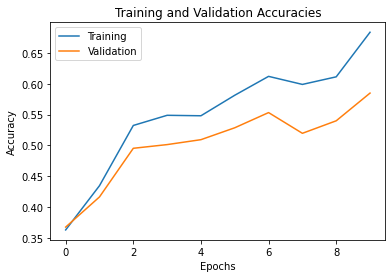

In [241]:
plt.plot(tc1, label='Training')
plt.plot(vc1, label='Validation')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

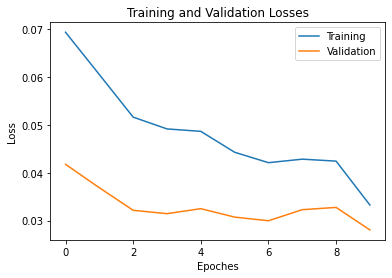

In [242]:
tl=[]
for i in tl1:
    tl.append(i.cpu().item())
vl=[]
for i in vl1:
    vl.append(i.cpu().item())
plt.plot(list(tl), label='Training')
plt.plot(list(vl), label='Validation')
plt.title('Training and Validation Losses')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [243]:
model.eval() # sets model in evaluation (inference) mode. 
correct = 0
device="cuda:0"
with torch.no_grad(): # stop storing gradients for the variables
    for data, target in a[2]:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True) # get the index of maximum fc output. 
        correct += pred.eq(target.view_as(pred)).sum().item()
    val_acc=correct / len(a[2].dataset)

In [244]:
val_acc

0.516